<a href="https://colab.research.google.com/github/Suyash018/101_food_class_classification/blob/main/Food_101_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi


Sat Mar 18 20:15:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

Importing food 101 dataset from tensorflow dataset

In [ ]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
(train_data,test_data),ds_info=tfds.load(name='food101',
                                         split=['train','validation'],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names=ds_info.features['label'].names
class_names[:10]#checking class names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
for image,label in train_one_sample:
  print(image.shape)
  print(image.dtype)

(512, 512, 3)
<dtype: 'uint8'>


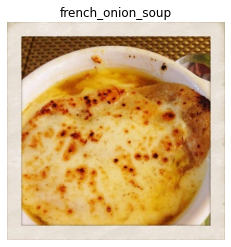

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) 
plt.axis(False);

Preprocess the image:
  1. Shape is incosistent in dataset so reshaping the image
  2. Convert unit8 to float

In [ ]:
def preprocess_img(image, label, img_shape=224):
  
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tupl

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Mixed precision 

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 


In [ ]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)


<Policy "mixed_float16">

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 

# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
non_finetuned_model = model.fit(train_data, 
                                epochs=3,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=int(0.15 * len(test_data)),verbose=1)

Epoch 1/3
2368/2368 [==============================] - 206s 79ms/step - loss: 1.7169 - accuracy: 0.5831 - val_loss: 1.1276 - val_accuracy: 0.6973
Epoch 2/3
2368/2368 [==============================] - 185s 77ms/step - loss: 1.1994 - accuracy: 0.6897 - val_loss: 1.0367 - val_accuracy: 0.7164
Epoch 3/3
2368/2368 [==============================] - 179s 75ms/step - loss: 1.0539 - accuracy: 0.7240 - val_loss: 0.9975 - val_accuracy: 0.7233


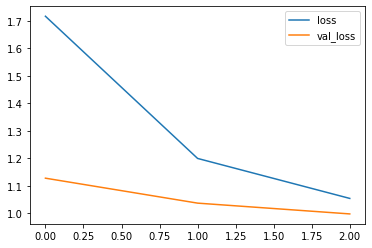

In [ ]:
import pandas as pd

history_df = pd.DataFrame(non_finetuned_model.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, 
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

3 epochs early stopping

In [ ]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3) 

In [ ]:
model1 = tf.keras.Model(inputs, outputs)
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

finetuned_model = model1.fit(train_data,
                            epochs=15, # fine-tune for a maximum of 100 epochs
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                            callbacks=[
                                early_stopping, # stop model after X epochs of no improvements
                                reduce_lr],verbose=1)

Epoch 1/15
2368/2368 [==============================] - 187s 75ms/step - loss: 0.6920 - accuracy: 0.8163 - val_loss: 0.9927 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 2/15
2368/2368 [==============================] - 180s 75ms/step - loss: 0.6626 - accuracy: 0.8245 - val_loss: 1.0057 - val_accuracy: 0.7272 - lr: 0.0010
Epoch 3/15
2368/2368 [==============================] - ETA: 0s - loss: 0.6392 - accuracy: 0.8307
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 180s 75ms/step - loss: 0.6392 - accuracy: 0.8307 - val_loss: 1.0071 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 4/15
2368/2368 [==============================] - 181s 76ms/step - loss: 0.5494 - accuracy: 0.8635 - val_loss: 0.9745 - val_accuracy: 0.7415 - lr: 2.0000e-04
Epoch 5/15
2368/2368 [==============================] - 182s 76ms/step - loss: 0.5401 - accuracy: 0.8680 - val_loss: 0.9810 - val_accuracy: 0.7368 - lr: 2.0000e-04
Epoch 6/15
2368/2368 [======

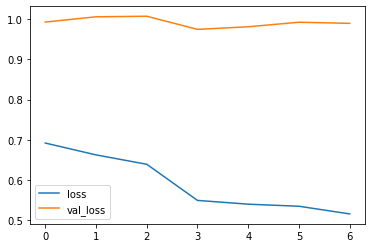

In [ ]:
history_df = pd.DataFrame(finetuned_model.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [ ]:
pred = model1.predict(test_data)

790/790 [==============================] - 62s 76ms/step
